In [1]:
import numpy as np
from numpy.random import uniform
from scipy.integrate import solve_ivp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

np.random.seed(42)

#### The Lorenz system of differential equations

$
\begin{align*}
\dot{x}  &= \sigma(y - x)\\
\dot{y}  &= x(\rho - z) - y\\
\dot{z}  &= xy - \beta z\\
\end{align*}
$

In [2]:
# Simulate the Lorenz System
tstart, tstop = 0, 8
dt = 0.01
timepoints = np.arange(tstart, tstop + dt/2, dt)
σ, ρ, β = 10, 28, 8/3

ntrials = 100
ntimes = len(timepoints) - 1

def lorenz(t, x_t, σ=σ, ρ=ρ, β=β):
    """Lorenz differential equation, returns LHS (derivatives) at a point `x_t`."""
    x, y, z = x_t
    return σ*(y - x), x*(ρ - z) - y, x*y - β*z

# Initial conditions
x_0s = uniform(-15, 15, size=(ntrials, 3)) 

# Resulting trajectories
xs = np.asarray([
    solve_ivp(lorenz, (tstart, tstop), x_0, t_eval=timepoints).y.T
    for x_0 in x_0s
])

# Time point and following one as input and output for neural net model
# Reshaping will stack all time points for one trial together, then the following trial
nn_input = xs[:, :-1, :].reshape(ntrials * ntimes, 3)
nn_output = xs[:, 1:, :].reshape(ntrials * ntimes, 3)

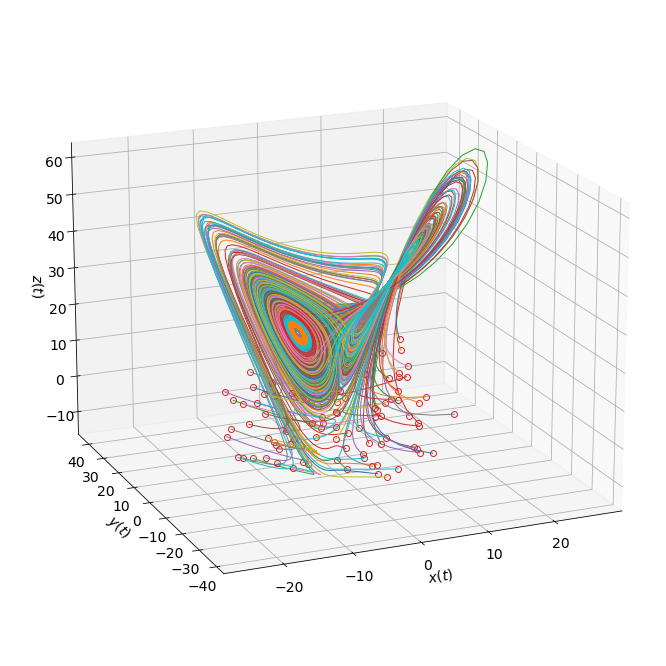

In [3]:
# Figure 6.14
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(12, 12))
for x_0, x in zip(x_0s, xs):
    ax.plot(*x_0, 'o', color='C3', fillstyle='none')
    ax.plot(*x.T, linewidth=1)

ax.set_xlabel('$x(t)$')
ax.set_ylabel('$y(t)$')
ax.set_zlabel('$z(t)$')
ax.view_init(18, -113)

In [4]:
# Create Neural Net model
model = Sequential([
    Dense(10, activation='sigmoid'),
    Dense(10, activation='gelu'),
    Dense(10, activation='linear'),
    Dense(3)
])
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

# Fit model to trajectory data
history = model.fit(nn_input, nn_output, epochs=2000, verbose=0, validation_split=0.1)

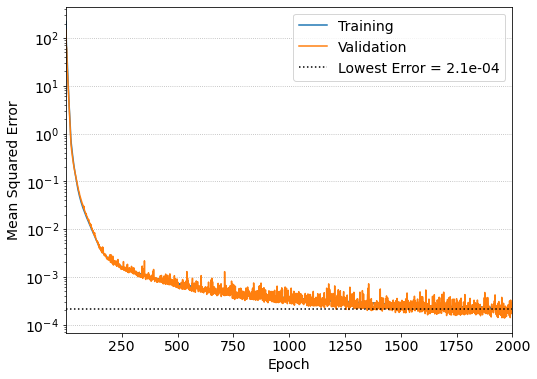

In [5]:
# Figure 6.15
losses = history.history['loss']
val_losses = history.history['val_loss']

fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogy(range(1, len(losses)+1), losses, label='Training')
ax.semilogy(range(1, len(val_losses)+1), val_losses, label='Validation')

ax.axhline(np.min(losses), color='black', linestyle=':', label=f'Lowest Error = {np.min(losses):0.1e}')

ax.grid(axis='y', linestyle=':')
ax.margins(0, 0.05)
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')
ax.legend();

In [6]:
# Compare nn model with ground truth from Lorenz equation for trajectories from two (random) starting points
ntrials = 2
x_0s = uniform(-10, 10, size=(ntrials, 3)) 
xs = np.asarray([
    solve_ivp(lorenz, (tstart, tstop), x_0, t_eval=timepoints).y.T
    for x_0 in x_0s
])

def nnint(model, x_0, timepoints):
    x_prev = x_0.reshape((1, 3))
    x = [x_prev]
    for _ in timepoints[1:]:
        x_new = model.predict(x_prev)
        x.append(x_new)
        x_prev = x_new
    return np.squeeze(x)

nn_xs = np.array([
    nnint(model, x_0, timepoints)
    for x_0 in x_0s
])

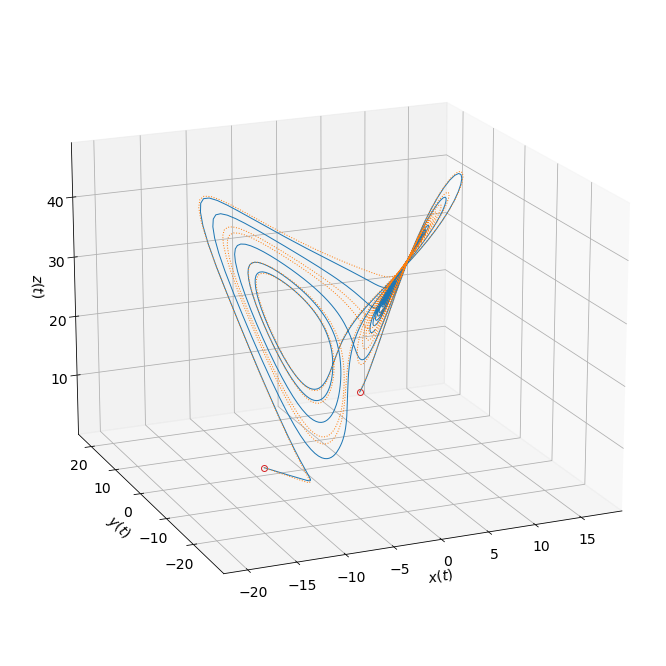

In [7]:
# Figure 6.16
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(12, 12))
for x_0, x, nn_x in zip(x_0s, xs, nn_xs):
    ax.plot(*x_0, 'o', color='C3', fillstyle='none')
    ax.plot(*x.T, linewidth=1, color='C0')
    ax.plot(*nn_x.T, ':', linewidth=1, color='C1')

ax.set_xlabel('$x(t)$')
ax.set_ylabel('$y(t)$')
ax.set_zlabel('$z(t)$')
ax.view_init(18, -113)

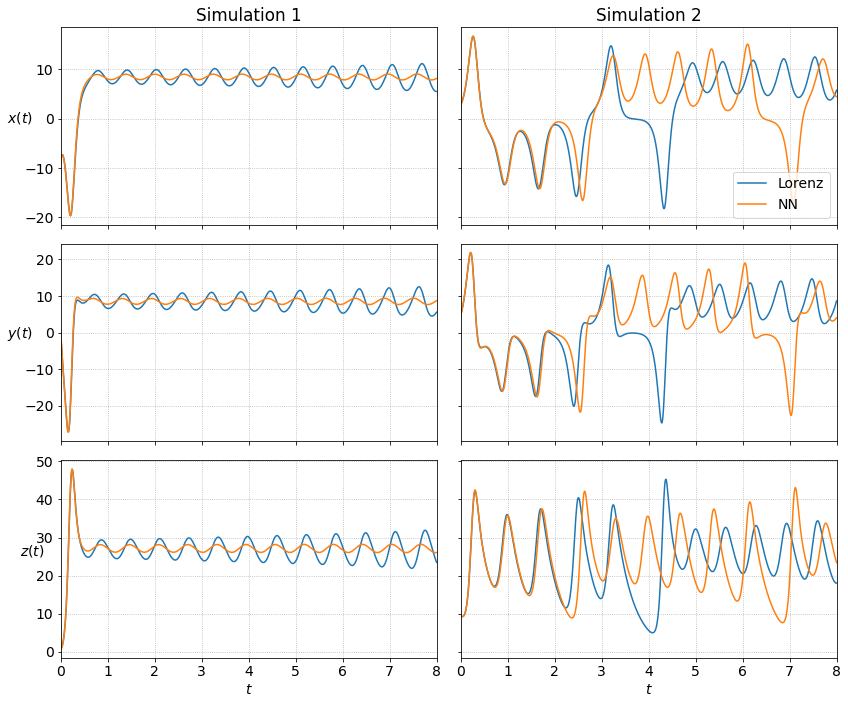

In [8]:
# Figure 6.17
fig, axss = plt.subplots(3, ntrials, sharex=True, sharey='row', figsize=(6*ntrials, 10))
for axs, x, nn_x in zip(axss.T, xs, nn_xs):
    for ax, x_i, nn_x_i in zip(axs, x.T, nn_x.T):
        ax.plot(timepoints, x_i, label='Lorenz')
        ax.plot(timepoints, nn_x_i, label='NN')
        ax.margins(0, 0.05)
        ax.grid(True, linestyle=':')

axss[0, 0].set_ylabel('$x(t)$', rotation=0)
axss[1, 0].set_ylabel('$y(t)$', rotation=0)
axss[2, 0].set_ylabel('$z(t)$', rotation=0)
for i, ax in enumerate(axss[0]):
    ax.set_title(f'Simulation {i+1}')
for ax in axss[-1]:
    ax.set_xlabel('$t$')
axss[0, -1].legend()
plt.tight_layout()